In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet201

In [10]:
path_dataset = 'E:\Datasets\FaceMaskDataset\Train'
os.listdir(path_dataset)

['WithMask', 'WithoutMask']

In [11]:
print('total WithMask images  :', 
      len(os.listdir(path_dataset + '/WithMask')))
print('total WithoutMask images :', 
      len(os.listdir(path_dataset + '/WithoutMask')))

total WithMask images  : 5400
total WithoutMask images : 5400


**Image Generator**

In [13]:
dataset_dir = os.path.join(path_dataset)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size = (50, 50),
    batch_size = 128,
    class_mode = 'binary',
    color_mode = 'rgb',
    subset = 'training'
)

valid_generator = valid_datagen.flow_from_directory(
    dataset_dir,
    target_size = (50, 50),
    batch_size = 128,
    class_mode = 'binary',
    color_mode = 'rgb',
    subset = 'validation'
)

Found 8640 images belonging to 2 classes.
Found 2160 images belonging to 2 classes.


**Callbacks**

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') > 0.95):
            print("\nAccuracy Validasi telah mencapai > 95%!")
            self.model.stop_training = True

callbacks = myCallback()

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

**Modeling**

In [21]:
model = tf.keras.models.Sequential([
    DenseNet201(weights='imagenet', include_top=False, input_shape=(50,50,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.layers[0].trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               576300    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)              

In [22]:
hist = model.fit(train_generator,
                 epochs = 50,
                 validation_data = valid_generator,
                 callbacks = [es],
                 verbose = 1)

Epoch 1/50
68/68 [==============================] - 437s 6s/step - loss: 0.1434 - accuracy: 0.9461 - val_loss: 16.0991 - val_accuracy: 0.6185
Epoch 2/50
68/68 [==============================] - 401s 6s/step - loss: 0.0383 - accuracy: 0.9887 - val_loss: 0.0687 - val_accuracy: 0.9856
Epoch 3/50
68/68 [==============================] - 419s 6s/step - loss: 0.0220 - accuracy: 0.9941 - val_loss: 0.5071 - val_accuracy: 0.9176
Epoch 4/50
68/68 [==============================] - 400s 6s/step - loss: 0.0167 - accuracy: 0.9943 - val_loss: 0.0753 - val_accuracy: 0.9810
Epoch 5/50
68/68 [==============================] - 394s 6s/step - loss: 0.0148 - accuracy: 0.9961 - val_loss: 0.0192 - val_accuracy: 0.9931
Epoch 6/50
68/68 [==============================] - 408s 6s/step - loss: 0.0093 - accuracy: 0.9963 - val_loss: 0.0179 - val_accuracy: 0.9954
Epoch 7/50
68/68 [==============================] - 416s 6s/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.0110 - val_accuracy: 0.9958
Epoch 8/50
6

**Plot Loss and Accuracy**

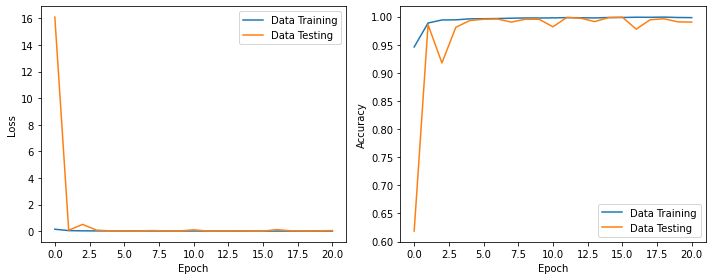

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(hist.history['loss'], label='Data Training')
ax[0].plot(hist.history['val_loss'], label='Data Testing')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='Data Training')
ax[1].plot(hist.history['val_accuracy'], label='Data Testing')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

**Save Model HDF5 Format**

In [24]:
model.save('mask_model.h5')

**Save Model to TF-Lite**

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('mask_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Acer\AppData\Local\Temp\tmp1coq4b84\assets
